# Bayesian Neural Network - NARX

In [1]:
import torch
device = 'cuda'
torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [2]:
import os
import csv
from functools import partial
import numpy as np
import numpy.random as rnd
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [4]:
from pyro.nn import module
from pyro.nn import PyroSample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.bnn import HiddenLayer

In [5]:
from util import summary

## Load data

In [6]:
# Read data from CSV file
dataset = pd.read_csv('../data/silverbox/SNLS80mV.csv')

# Select input and output signals
input_signal = dataset["V1"].values
output_signal = dataset["V2"].values

# Time horizon
T = np.shape(input_signal)[0]

In [7]:
# NARX orders
order_u = 2
order_y = 2
order = 1 + order_u + order_y

# Initialize feature array
signal_lag = np.zeros((T,order))

# Lagged signals as features
for k in range(max(order_u,order_y),T):
    signal_lag[k,:] = np.hstack(([input_signal[range(k,k-order_u-1,-1)], output_signal[range(k-1,k-order_u-1,-1)]]))

In [8]:
# Split training set
t_trn = range(40101,131072)
u_trn = input_signal[t_trn]
x_trn = signal_lag[t_trn,:]
y_trn = output_signal[t_trn]
T_trn = len(t_trn);

# Split validation set
t_val = range(101,40100)
u_val = input_signal[t_val]
x_val = signal_lag[t_val,:]
y_val = output_signal[t_val]
T_val = len(t_val);

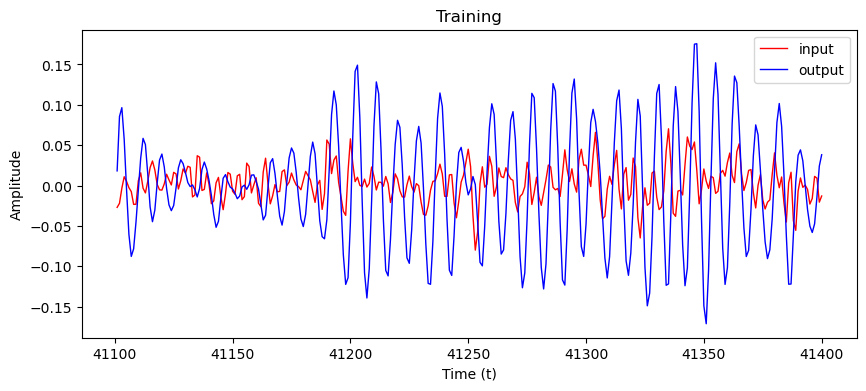

In [12]:
# Plot training signal
zoom = slice(1000,1300)
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1)
ax.plot(t_trn[zoom], u_trn[zoom], c="red", lw=1, label="input");
ax.plot(t_trn[zoom], y_trn[zoom], c="blue", lw=1, label="output"); 
ax.set_title("Training");
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

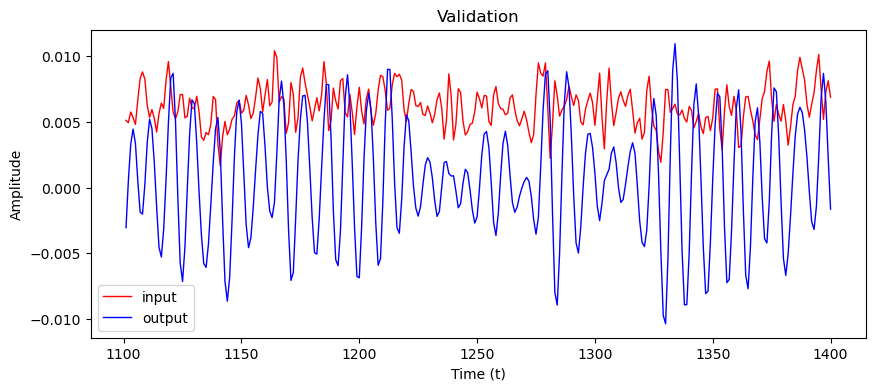

In [13]:
# Plot validation signal
zoom = slice(1000,1300)
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1)
ax.plot(t_val[zoom], u_val[zoom], c="red", lw=1, label="input");
ax.plot(t_val[zoom], y_val[zoom], c="blue", lw=1, label="output"); 
ax.set_title("Validation");
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [14]:
# Cast to tensors
trn_u = torch.tensor(u_trn, dtype=torch.float).to(device)
trn_x = torch.tensor(x_trn, dtype=torch.float).to(device)
trn_y = torch.tensor(y_trn, dtype=torch.float).to(device)

val_u = torch.tensor(u_val, dtype=torch.float).to(device)
val_x = torch.tensor(x_val, dtype=torch.float).to(device)
val_y = torch.tensor(y_val, dtype=torch.float).to(device)

## Model 0: Bayesian linear regression

In [15]:
class BayesianLinearRegression(PyroModule):
    def __init__(self, in_features, out_features, device='cpu'):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        self.device = device

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [16]:
# Define model and inference procedure
model = BayesianLinearRegression(order, 1, device=device).to(device)
guide = AutoDiagonalNormal(model).to(device)
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [17]:
pyro.clear_param_store()

# Train model
num_iterations = 5000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: 94.2046
[iteration 1001] loss: 0.7654
[iteration 2001] loss: 0.3824
[iteration 3001] loss: -3.3173
[iteration 4001] loss: -4.1858


### Model evaluation

In [18]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples_BLR = predictive(val_x)
pred_summary = summary(samples_BLR)
mu_BLR = pred_summary["_RETURN"]

In [19]:
m0_MAP = mu_BLR["mean"].to('cpu')
m0_σ05 = mu_BLR["5%"].to('cpu')
m0_σ95 = mu_BLR["95%"].to('cpu')

In [20]:
RMS_BLR = np.array(np.sqrt(torch.mean((val_y.to('cpu') - m0_MAP)**2)))

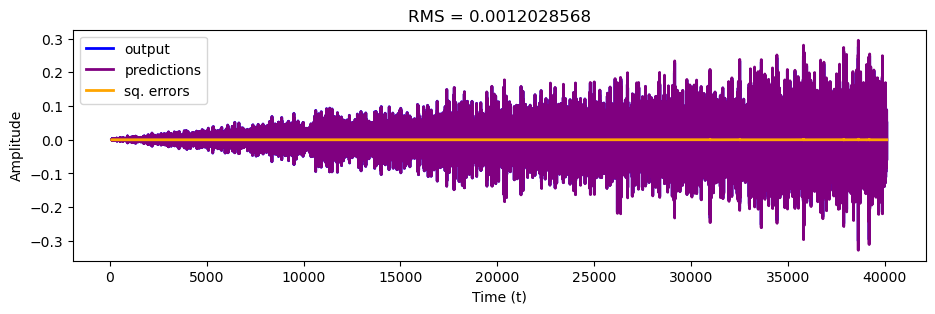

In [22]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y.to('cpu'), c="blue", lw=2, label="output"); 
ax.plot(t_val, m0_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m0_σ05, m0_σ95, color="purple", alpha=0.5)
ax.plot(t_val, (m0_MAP - val_y.to('cpu'))**2, c="orange", lw=2, label="sq. errors")
ax.set_title("RMS = " + str(RMS_BLR));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [23]:
fig.savefig("figures/NARX-BLR-silverbox.png");

## Model 1: Bayesian neural network (Sequential)

In [28]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(order, 32),
     nn.Sigmoid(),
     nn.Linear(32, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [29]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0, 1))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [30]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network).to(device)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.01}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [ ]:
pyro.clear_param_store()

In [38]:
# Train model
num_iterations = 10000
for j in range(num_iterations):
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: -4.9085
[iteration 1001] loss: -5.1600
[iteration 2001] loss: -4.1020
[iteration 3001] loss: -4.8878
[iteration 4001] loss: -5.0689
[iteration 5001] loss: -5.3679
[iteration 6001] loss: -5.0805
[iteration 7001] loss: -5.1402
[iteration 8001] loss: -5.1854
[iteration 9001] loss: -4.5806


### Model evaluation

In [44]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples_BNN1 = predictive(val_x)
pred_summary = summary(samples_BNN1)
mu_BNN1 = pred_summary["_RETURN"]

In [45]:
m1_MAP = mu_BNN1["mean"].to('cpu')
m1_σ05 = mu_BNN1["5%"].to('cpu')
m1_σ95 = mu_BNN1["95%"].to('cpu')

In [46]:
RMS_BNN1 = np.array(np.sqrt(torch.mean((val_y.to('cpu') - m1_MAP)**2)))

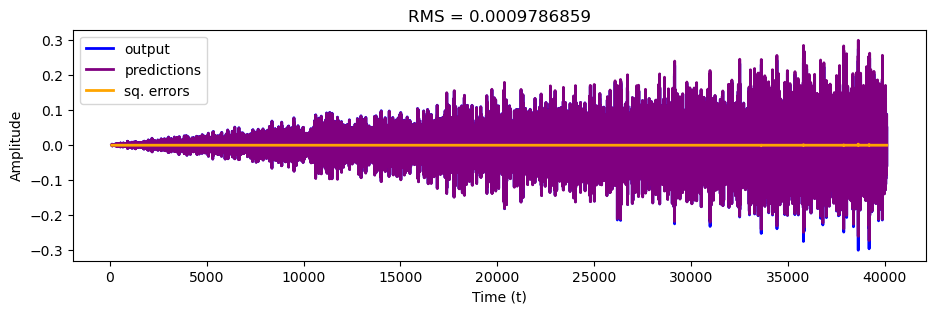

In [47]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y.to('cpu'), c="blue", lw=2, label="output"); 
ax.plot(t_val, m1_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m1_σ05, m1_σ95, color="purple", alpha=0.5)
ax.plot(t_val, (m1_MAP - val_y.to('cpu'))**2, c="orange", lw=2, label="sq. errors")
ax.set_title("RMS = " + str(RMS_BNN1));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [48]:
fig.savefig("figures/NARX-BNN1-silverbox.png");

## Model 2: Bayesian neural network (LeakyReLU)

In [49]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(order, 64),
     nn.LeakyReLU(),
     nn.Linear(64, 32),
     nn.Sigmoid(),
     nn.Linear(32, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [50]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0, 1))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [51]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network).to(device)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.03}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [52]:
pyro.clear_param_store()

In [61]:
# Train model
num_iterations = 20000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: -3.2789
[iteration 1001] loss: -2.4610
[iteration 2001] loss: 1.2599
[iteration 3001] loss: -1.3137
[iteration 4001] loss: -1.4637
[iteration 5001] loss: -1.4813
[iteration 6001] loss: -1.4593
[iteration 7001] loss: -1.4870
[iteration 8001] loss: -1.1662
[iteration 9001] loss: -1.4886
[iteration 10001] loss: -1.0055
[iteration 11001] loss: -1.4858
[iteration 12001] loss: -1.4651
[iteration 13001] loss: -1.4898
[iteration 14001] loss: -1.4955
[iteration 15001] loss: -1.4955
[iteration 16001] loss: -1.4977
[iteration 17001] loss: -1.4971
[iteration 18001] loss: -1.4992
[iteration 19001] loss: -1.5015


### Model evaluation

In [62]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples_BNN2 = predictive(val_x)
pred_summary = summary(samples_BNN2)
mu_BNN2 = pred_summary["_RETURN"]

In [63]:
m2_MAP = mu_BNN2["mean"].to('cpu')
m2_σ05 = mu_BNN2["5%"].to('cpu')
m2_σ95 = mu_BNN2["95%"].to('cpu')

In [64]:
RMS_BNN2 = np.array(np.sqrt(torch.mean((val_y.to('cpu') - m2_MAP)**2)))

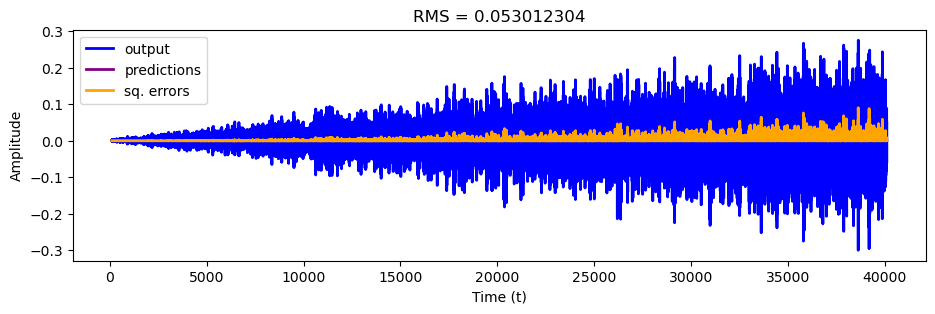

In [65]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y.to('cpu'), c="blue", lw=2, label="output"); 
ax.plot(t_val, m2_MAP, c="purple", lw=2, label="predictions")
ax.fill_between(t_val, m2_σ05, m2_σ95, color="purple", alpha=0.5)
ax.plot(t_val, (m2_MAP - val_y.to('cpu'))**2, c="orange", lw=2, label="sq. errors")
ax.set_title("RMS = " + str(RMS_BNN2));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [66]:
fig.savefig("figures/NARX-BNN2-silverbox.png");

## Model Comparison

In [67]:
print("RMS BLR  = " + str(RMS_BLR))
print("RMS BNN1 = " + str(RMS_BNN1))
print("RMS BNN2 = " + str(RMS_BNN2))

RMS BLR  = 0.0012028568
RMS BNN1 = 0.0009786859
RMS BNN2 = 0.053012304
